[View in Colaboratory](https://colab.research.google.com/github/miguelrq/GANs/blob/master/WGAN-CIFAR10.ipynb)

In [1]:
!pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 2.0MB 19.5MB/s 


In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x5b650000 @  0x7fb5aa60d1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [0]:
import argparse
import os
import numpy as np
import math

import torch.nn as nn
import torch.nn.functional as F
import torch

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable



In [0]:
os.makedirs('images', exist_ok=True)


n_epochs = 200
batch_size = 64
lr = 0.0002
n_cpu = 8
latent_dim = 100
img_size = 32
channels = 3
n_critic = 0.01
clip_value = 0.01
sample_interval = 800

In [0]:
img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [  nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [9]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
os.makedirs('../../data/CIFAR10', exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../../data/CIFAR10', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [0]:
# Optimizers
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=lr)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [13]:
# ----------
#  Training
# ----------

d_learning = []
g_learning = []

batches_done = 0

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z).detach()
        # Adversarial loss
        loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))

        loss_D.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train the generator every n_critic iterations
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z)
            # Adversarial loss
            loss_G = -torch.mean(discriminator(gen_imgs))

            loss_G.backward()
            optimizer_G.step()

            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs,
                                                            batches_done % len(dataloader), len(dataloader),
                                                            loss_D.item(), loss_G.item()))
            d_learning.append(loss_D.item())
            g_learning.append(loss_G.item())
        
        
        
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], 'images/%08d.png' % batches_done, nrow=5, normalize=True)
        batches_done += 1
        
        
        
       

[Epoch 0/200] [Batch 0/782] [D loss: -0.074866] [G loss: -0.011301]
[Epoch 1/200] [Batch 0/782] [D loss: -27.717657] [G loss: -0.061768]
[Epoch 2/200] [Batch 0/782] [D loss: -21.711731] [G loss: -2.813910]
[Epoch 3/200] [Batch 0/782] [D loss: -16.376551] [G loss: -6.726642]
[Epoch 4/200] [Batch 0/782] [D loss: -9.868048] [G loss: -8.559155]
[Epoch 5/200] [Batch 0/782] [D loss: -13.520870] [G loss: -0.198154]
[Epoch 6/200] [Batch 0/782] [D loss: -8.275149] [G loss: -0.064673]
[Epoch 7/200] [Batch 0/782] [D loss: -10.945979] [G loss: -0.110113]
[Epoch 8/200] [Batch 0/782] [D loss: -4.352921] [G loss: 0.113685]
[Epoch 9/200] [Batch 0/782] [D loss: -20.931473] [G loss: 2.081956]
[Epoch 10/200] [Batch 0/782] [D loss: -20.836538] [G loss: 0.950482]
[Epoch 11/200] [Batch 0/782] [D loss: -19.547625] [G loss: 0.247457]
[Epoch 12/200] [Batch 0/782] [D loss: -21.014624] [G loss: 0.247306]
[Epoch 13/200] [Batch 0/782] [D loss: -19.807495] [G loss: 0.274782]
[Epoch 14/200] [Batch 0/782] [D loss: -1

In [14]:
!ls images

00000000.png  00032000.png  00064000.png  00096000.png	00128000.png
00000800.png  00032800.png  00064800.png  00096800.png	00128800.png
00001600.png  00033600.png  00065600.png  00097600.png	00129600.png
00002400.png  00034400.png  00066400.png  00098400.png	00130400.png
00003200.png  00035200.png  00067200.png  00099200.png	00131200.png
00004000.png  00036000.png  00068000.png  00100000.png	00132000.png
00004800.png  00036800.png  00068800.png  00100800.png	00132800.png
00005600.png  00037600.png  00069600.png  00101600.png	00133600.png
00006400.png  00038400.png  00070400.png  00102400.png	00134400.png
00007200.png  00039200.png  00071200.png  00103200.png	00135200.png
00008000.png  00040000.png  00072000.png  00104000.png	00136000.png
00008800.png  00040800.png  00072800.png  00104800.png	00136800.png
00009600.png  00041600.png  00073600.png  00105600.png	00137600.png
00010400.png  00042400.png  00074400.png  00106400.png	00138400.png
00011200.png  00043200.png  00075200.png  001072

In [15]:
!ls images/ -l . | egrep -c '^-'

196


In [0]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('images/*.png'): #assuming gif
    im=Image.open(filename)
    image_list.append(im)

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def get_sample(array,x):
  steps = int(len(array)/(x-1))
  print(steps)
  new_array = []
  for i in range(0,x-1):
    print("-",i*steps)
    new_array.append(array[i*steps])
  new_array.append(array[-1])
  print(steps)
  print(len(new_array))
  return new_array

24
- 0
- 24
- 48
- 72
- 96
- 120
- 144
- 168
24
9


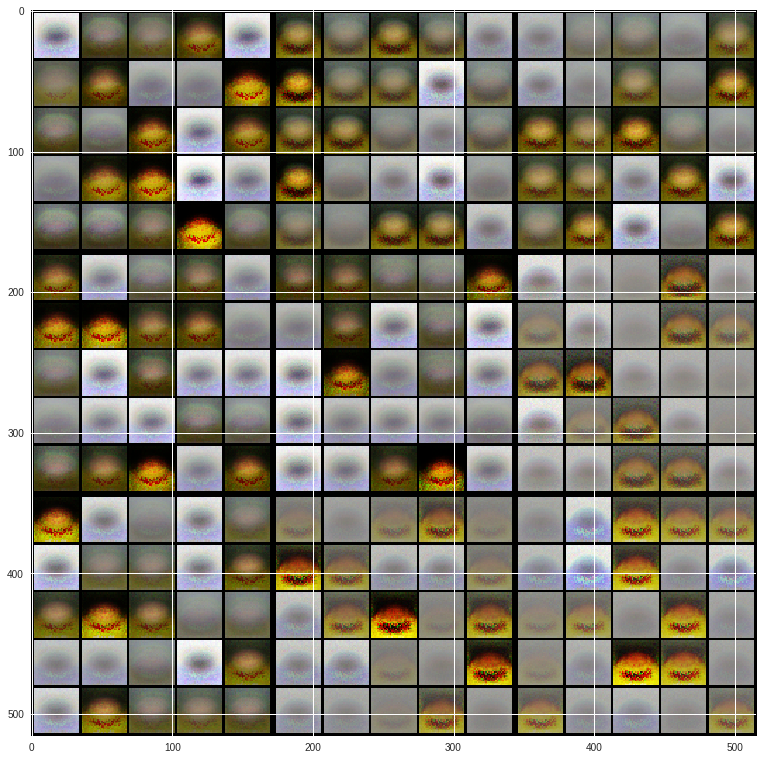

In [18]:

def gallery(array, ncols=3):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def make_array(image_array):      
    return np.array([np.array(img) for img in image_array])    

array = make_array(get_sample(image_list,9))
result = gallery(array)
plt.figure(figsize=(13,20))
plt.imshow(result)
plt.show()

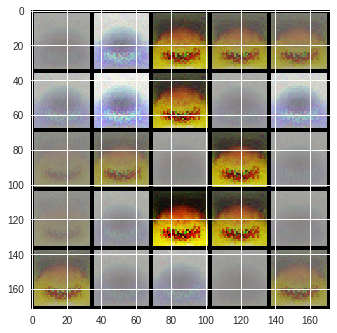

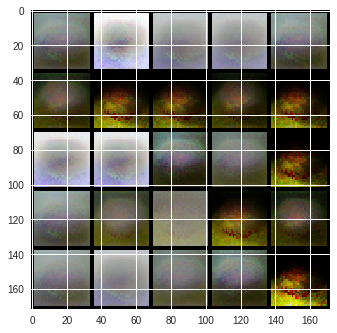

In [19]:
plt.imshow(image_list[-1])
plt.show()
plt.imshow(image_list[-2])
plt.show()

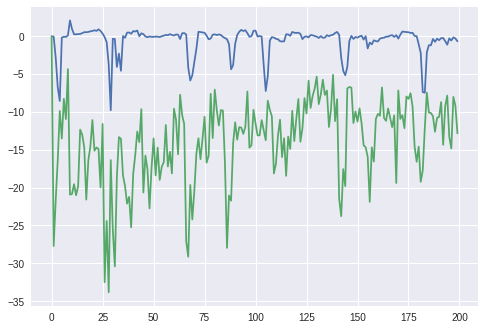

In [20]:
plt.plot(g_learning)
plt.plot(d_learning)
plt.show()